In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.decomposition import PCA

## **Data Preparation**

In [ ]:
# Load customer data
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')
products = pd.read_csv('Products.csv')

In [ ]:
# Merge transactions with products to get product information
transaction_details = pd.merge(transactions, products, on='ProductID')

In [ ]:
# Aggregate transaction details to get customer profiles
customer_profile = transaction_details.groupby('CustomerID').agg({
    'Category': lambda x: x.value_counts().index[0],  # Most common category
     # Total amount spent
    'TransactionID': 'count'  # Total number of transactions
}).reset_index()

# Merge customer profiles with customer data
customer_data = pd.merge(customers, customer_profile, on='CustomerID')

# **Feature Engineering**

In [23]:
# Encode categorical features
customer_data = pd.get_dummies(customer_data, columns=['Region', 'Category'])

# Standardize numerical features
scaler = StandardScaler()

# Drop non-numeric columns before scaling
columns_to_drop = ['CustomerID', 'CustomerName', 'SignupDate']
feature_columns = customer_data.drop(columns=columns_to_drop).columns

customer_data[feature_columns] = scaler.fit_transform(customer_data[feature_columns])

# Check the data after preprocessing
print(customer_data.head())

  CustomerID        CustomerName  SignupDate  TransactionID  Region_Asia  \
0      C0001    Lawrence Carroll  2022-07-10      -0.011458    -0.532795   
1      C0002      Elizabeth Lutz  2022-02-13      -0.467494     1.876893   
2      C0003      Michael Rivera  2024-03-07      -0.467494    -0.532795   
3      C0004  Kathleen Rodriguez  2022-10-09       1.356650    -0.532795   
4      C0005         Laura Weber  2022-08-15      -0.923530     1.876893   

   Region_Europe  Region_North America  Region_South America  Category_Books  \
0      -0.579284             -0.548319              1.540416       -0.548319   
1      -0.579284             -0.548319             -0.649175       -0.548319   
2      -0.579284             -0.548319              1.540416       -0.548319   
3      -0.579284             -0.548319              1.540416        1.823756   
4      -0.579284             -0.548319             -0.649175       -0.548319   

   Category_Clothing  Category_Electronics  Category_Home Deco

# **Clustering**

In [ ]:
# Define the range of clusters to evaluate
num_clusters_range = range(2, 9)

# Initialize variables to store the best model and metrics
best_db_index = float('inf')
best_num_clusters = None
best_kmeans_model = None

# Evaluate different numbers of clusters
for num_clusters in num_clusters_range:
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(customer_data[feature_columns])
    
    # Calculate Davies-Bouldin Index
    db_index = davies_bouldin_score(customer_data[feature_columns], cluster_labels)
    
    # Store the best model and metrics
    if db_index < best_db_index:
        best_db_index = db_index
        best_num_clusters = num_clusters
        best_kmeans_model = kmeans

print(f'Best Number of Clusters: {best_num_clusters}')
print(f'Best Davies-Bouldin Index: {best_db_index}')

Best Number of Clusters: 7
Best Davies-Bouldin Index: 1.0995971990467308


## **Cluster Visualization**

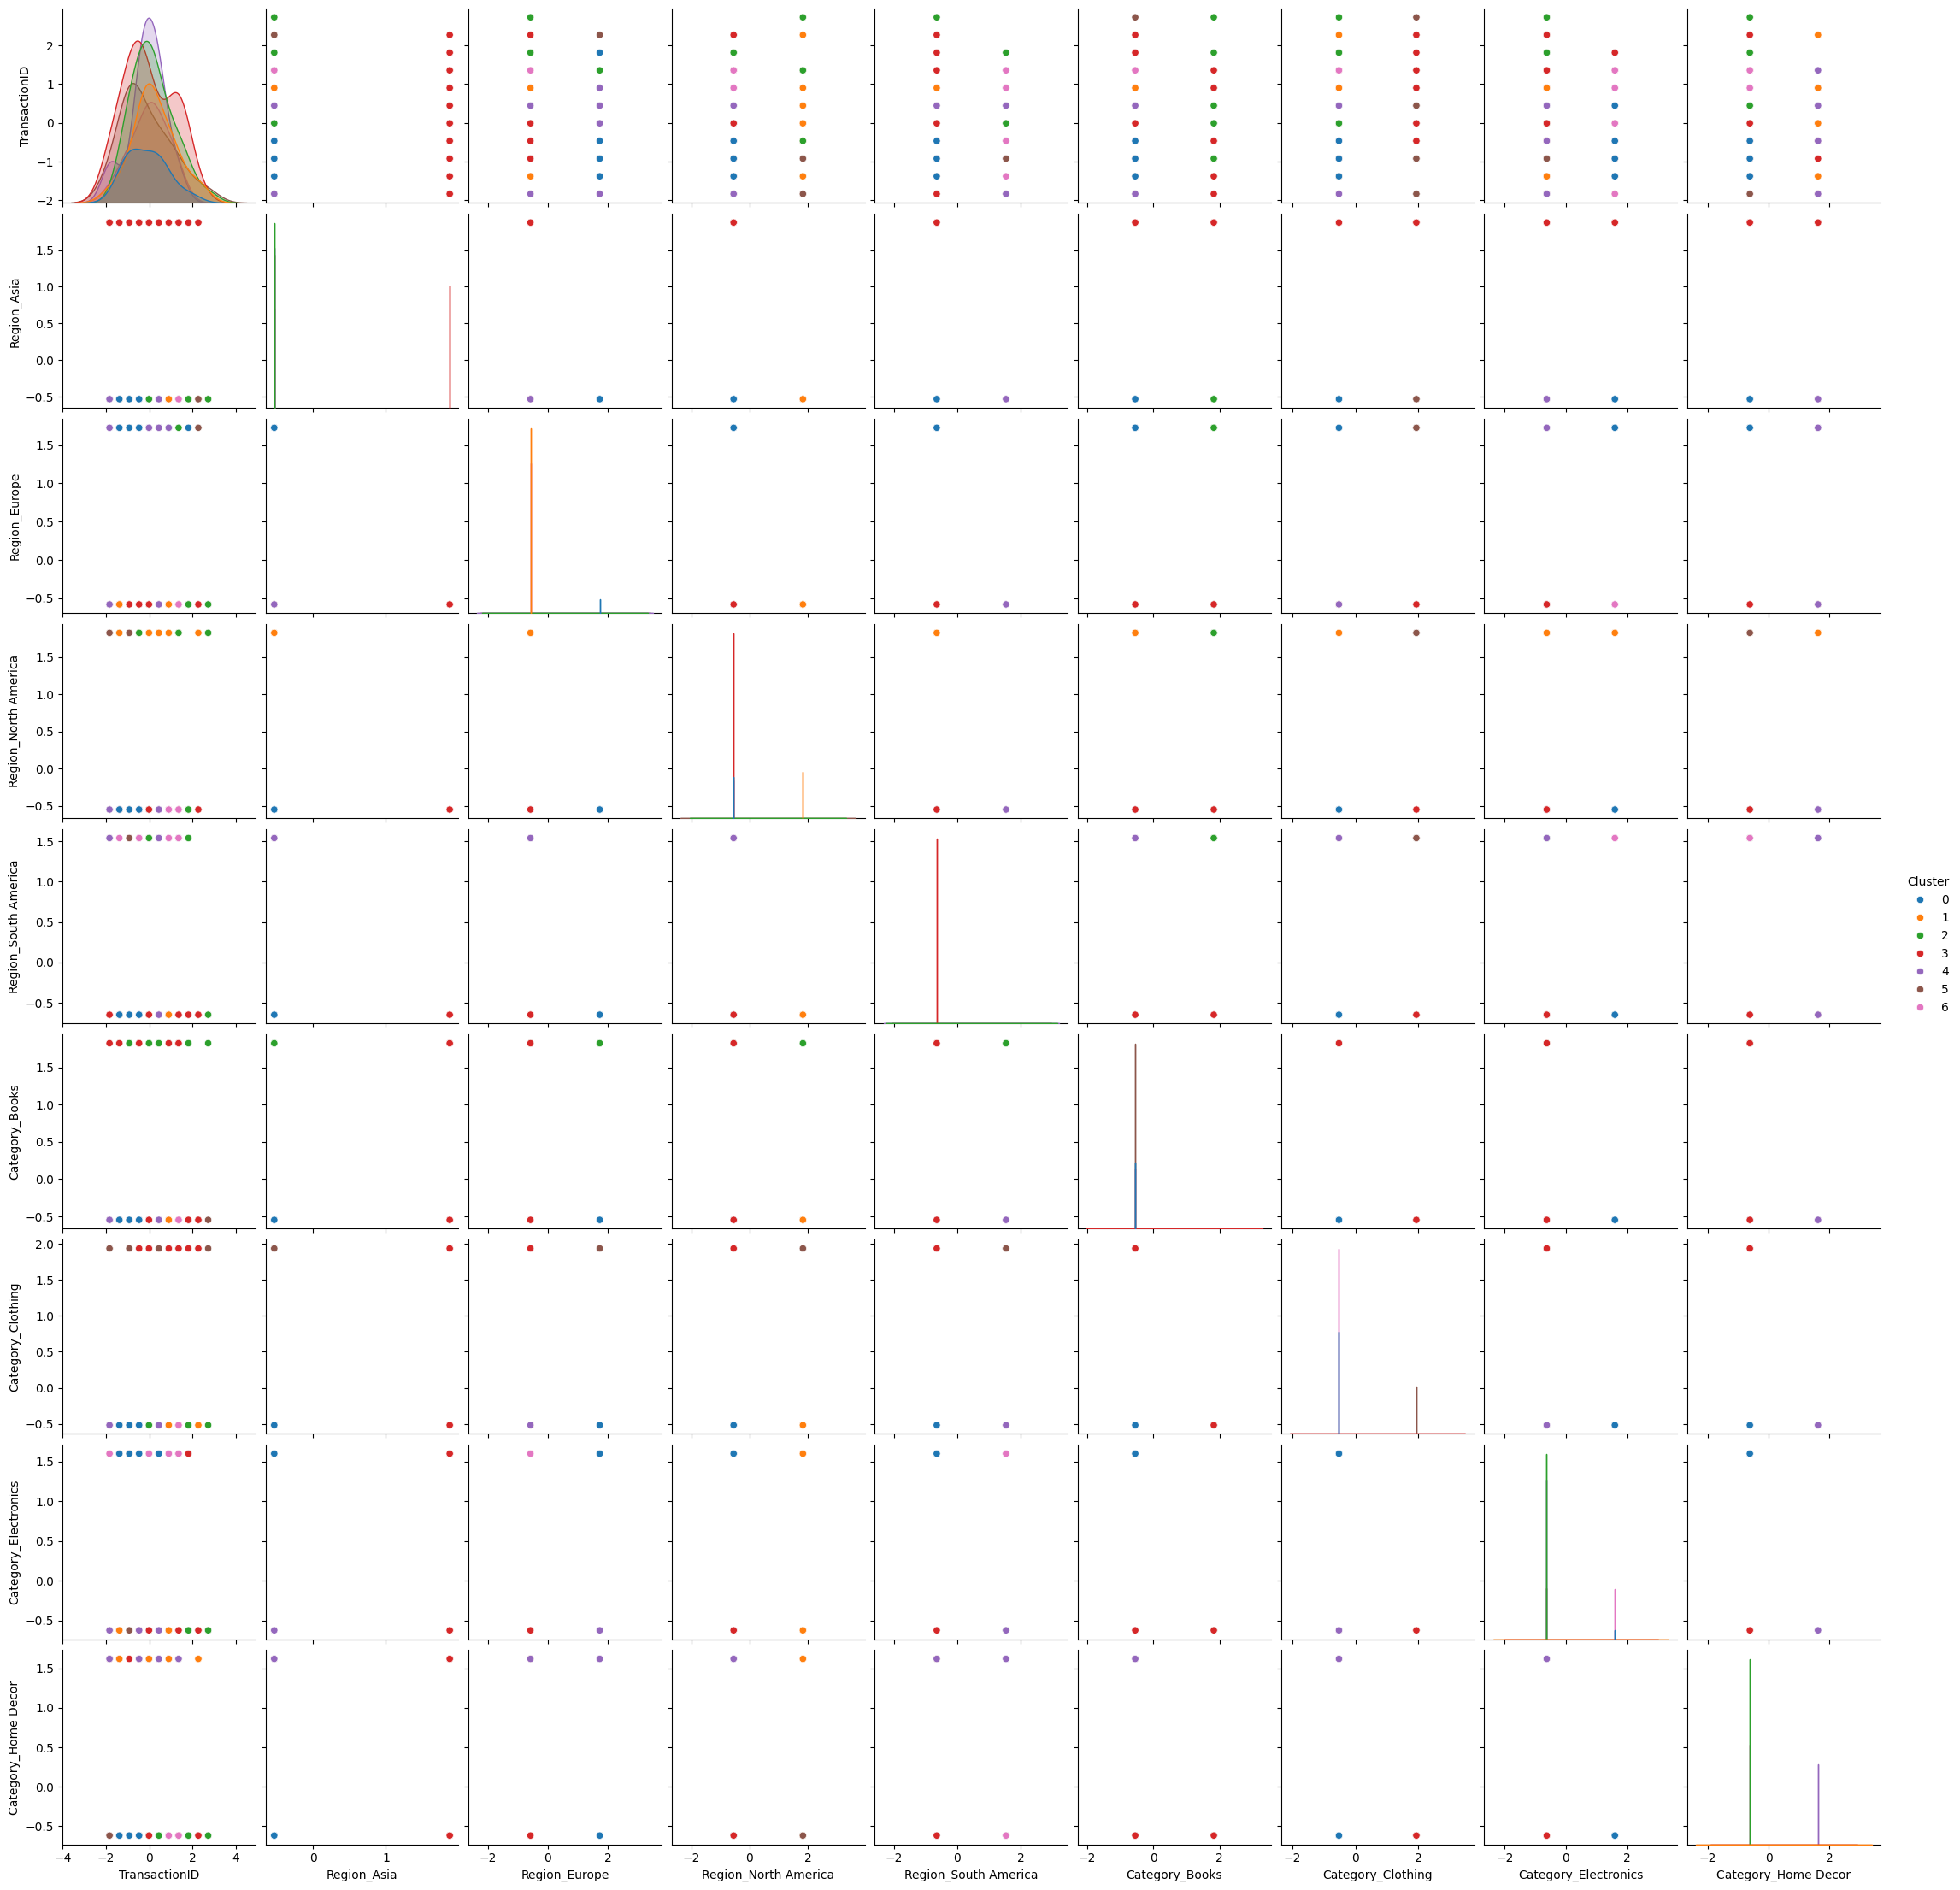

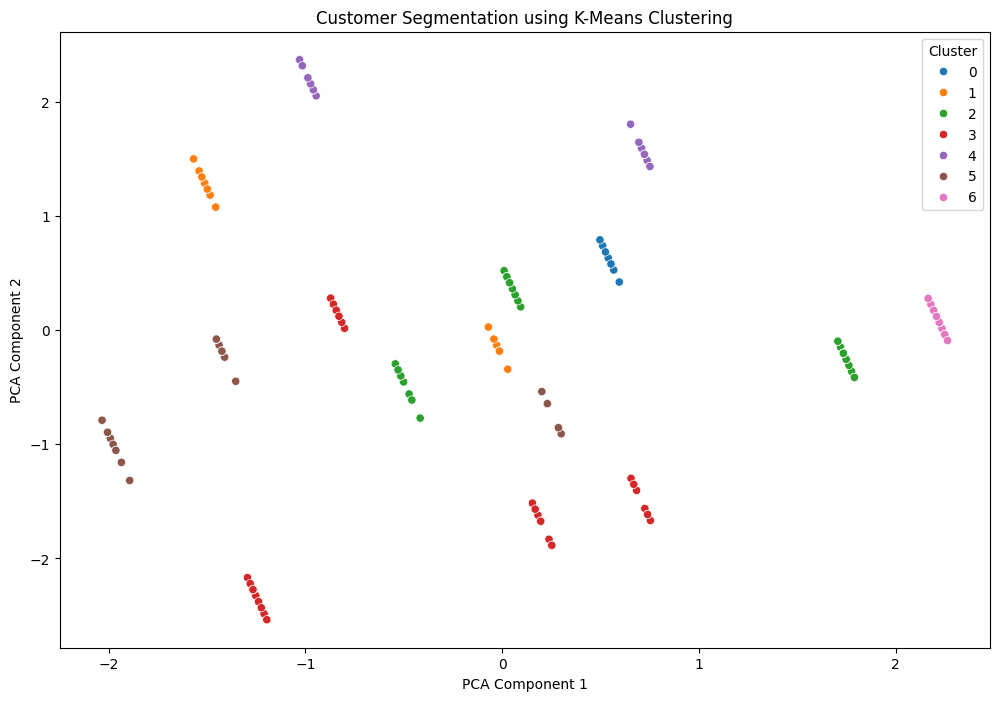

In [25]:
# Add cluster labels to the original data
customer_data['Cluster'] = best_kmeans_model.labels_

# Visualize the clusters using a pair plot
sns.pairplot(customer_data, hue='Cluster', palette='tab10')
plt.savefig('pair_plot.png')
plt.show()

# Another visualization using PCA for dimensionality reduction

pca = PCA(n_components=2)
customer_data_pca = pca.fit_transform(customer_data[feature_columns])

plt.figure(figsize=(12, 8))
sns.scatterplot(x=customer_data_pca[:, 0], y=customer_data_pca[:, 1], hue=customer_data['Cluster'], palette='tab10')
plt.title('Customer Segmentation using K-Means Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.savefig('pca_plot.png')
plt.show()